*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.2.0

torch 1.0.0


- Runs on CPU (not recommended here) or GPU (if available)

# Model Zoo -- Convolutional Autoencoder with Nearest-neighbor Interpolation (Trained on CelebA)

A convolutional autoencoder using nearest neighbor upscaling layers that compresses 128*128*3=49,152 pixel face images to an intermediate 1000-pixel representation (~50x reduction!). 

## Imports

In [2]:
import os

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

## Dataset

### Downloading the Dataset

Note that the ~200,000 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

1) Download and unzip the file `img_align_celeba.zip`, which contains the images in jpeg format.

2) Download the `list_eval_partition.txt` file, which contains  training/validation/test partitioning info

### Preparing the Dataset

In [3]:
df2 = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.head()

,Partition
Filename,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [4]:
df2.loc[df2['Partition'] == 0].to_csv('celeba-train.csv')
df2.loc[df2['Partition'] == 1].to_csv('celeba-valid.csv')
df2.loc[df2['Partition'] == 2].to_csv('celeba-test.csv')

(218, 178, 3)


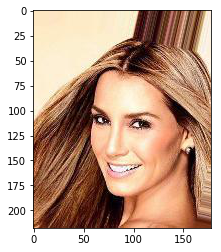

In [5]:
img = Image.open('img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Create a Custom Data Loader

In [6]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return self.img_names.shape[0]

In [7]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='img_align_celeba/',
                              transform=custom_transform)

BATCH_SIZE=128


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

## Settings

In [8]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 1e-4
num_epochs = 20

Device: cuda:2


### Model

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, dec_channels, latent_size):
        super(AutoEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.dec_channels = dec_channels
        self.latent_size = latent_size

        ###############
        # ENCODER
        ##############
        self.e_conv_1 = nn.Conv2d(in_channels, dec_channels, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_1 = nn.BatchNorm2d(dec_channels)

        self.e_conv_2 = nn.Conv2d(dec_channels, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_2 = nn.BatchNorm2d(dec_channels*2)

        self.e_conv_3 = nn.Conv2d(dec_channels*2, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_3 = nn.BatchNorm2d(dec_channels*4)

        self.e_conv_4 = nn.Conv2d(dec_channels*4, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_4 = nn.BatchNorm2d(dec_channels*8)

        self.e_conv_5 = nn.Conv2d(dec_channels*8, dec_channels*16, 
                                  kernel_size=(4, 4), stride=(2, 2), padding=1)
        self.e_bn_5 = nn.BatchNorm2d(dec_channels*16)
       
        self.e_fc_1 = nn.Linear(dec_channels*16*4*4, latent_size)

        ###############
        # DECODER
        ##############
        
        self.d_fc_1 = nn.Linear(latent_size, dec_channels*16*4*4)

        self.d_conv_1 = nn.Conv2d(dec_channels*16, dec_channels*8, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_1 = nn.BatchNorm2d(dec_channels*8)

        self.d_conv_2 = nn.Conv2d(dec_channels*8, dec_channels*4, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_2 = nn.BatchNorm2d(dec_channels*4)

        self.d_conv_3 = nn.Conv2d(dec_channels*4, dec_channels*2, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_3 = nn.BatchNorm2d(dec_channels*2)

        self.d_conv_4 = nn.Conv2d(dec_channels*2, dec_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        self.d_bn_4 = nn.BatchNorm2d(dec_channels)
        
        self.d_conv_5 = nn.Conv2d(dec_channels, in_channels, 
                                  kernel_size=(4, 4), stride=(1, 1), padding=0)
        
        
        # Reinitialize weights using He initialization
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()
            elif isinstance(m, torch.nn.Linear):
                nn.init.kaiming_normal_(m.weight.detach())
                m.bias.detach().zero_()


    def encode(self, x):
        
        #h1
        x = self.e_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.e_bn_1(x)
        
        #h2
        x = self.e_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)    
        x = self.e_bn_2(x)     

        #h3
        x = self.e_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_3(x)
        
        #h4
        x = self.e_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_4(x)
        
        #h5
        x = self.e_conv_5(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True) 
        x = self.e_bn_5(x)        
        
        #fc
        x = x.view(-1, self.dec_channels*16*4*4)
        x = self.e_fc_1(x)
        return x

    def decode(self, x):
        
        # h1
        #x = x.view(-1, self.latent_size, 1, 1)
        x = self.d_fc_1(x)
        
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)  
        x = x.view(-1, self.dec_channels*16, 4, 4) 

        
        # h2
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_1(x)
        
        # h3
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_2(x)
        
        # h4
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_3(x)  

        # h5
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_4(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.d_bn_4(x)
        
        
        # out
        x = F.interpolate(x, scale_factor=2)
        x = F.pad(x, pad=(2, 1, 2, 1), mode='replicate')
        x = self.d_conv_5(x)
        x = torch.sigmoid(x)
        
        return x

    def forward(self, x):
        z = self.encode(x)
        decoded = self.decode(z)
        return z, decoded

## Training

In [10]:
##########################
### TRAINING
##########################

epoch_start = 1


torch.manual_seed(random_seed)
model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


################## Load previous
# the code saves the autoencoder
# after each epoch so that in case
# the training process gets interrupted,
# we will not have to start training it
# from scratch
files = os.listdir()

for f in files:
    if f.startswith('autoencoder_i_') and f.endswith('.pt'):
        print('Load', f)
        epoch_start = int(f.split('_')[-2]) + 1
        model.load_state_dict(torch.load(f))
        break
##################


for epoch in range(epoch_start, num_epochs+1):
    
    
    for batch_idx, features in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = features.to(device)
        
        ### FORWARD AND BACK PROP
        latent_vector, decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch, num_epochs, batch_idx, 
                     len(train_loader), cost))

        
    # Save model
    if os.path.isfile('autoencoder_i_%d_%s.pt' % (epoch-1, device)):
        os.remove('autoencoder_i_%d_%s.pt' % (epoch-1, device))
    torch.save(model.state_dict(), 'autoencoder_i_%d_%s.pt' % (epoch, device))

Epoch: 001/020 | Batch 0000/1272 | Cost: 0.1234
Epoch: 001/020 | Batch 0500/1272 | Cost: 0.0116
Epoch: 001/020 | Batch 1000/1272 | Cost: 0.0091
Epoch: 002/020 | Batch 0000/1272 | Cost: 0.0085
Epoch: 002/020 | Batch 0500/1272 | Cost: 0.0071
Epoch: 002/020 | Batch 1000/1272 | Cost: 0.0064
Epoch: 003/020 | Batch 0000/1272 | Cost: 0.0067
Epoch: 003/020 | Batch 0500/1272 | Cost: 0.0059
Epoch: 003/020 | Batch 1000/1272 | Cost: 0.0055
Epoch: 004/020 | Batch 0000/1272 | Cost: 0.0064
Epoch: 004/020 | Batch 0500/1272 | Cost: 0.0057
Epoch: 004/020 | Batch 1000/1272 | Cost: 0.0050
Epoch: 005/020 | Batch 0000/1272 | Cost: 0.0051
Epoch: 005/020 | Batch 0500/1272 | Cost: 0.0045
Epoch: 005/020 | Batch 1000/1272 | Cost: 0.0044
Epoch: 006/020 | Batch 0000/1272 | Cost: 0.0047
Epoch: 006/020 | Batch 0500/1272 | Cost: 0.0045
Epoch: 006/020 | Batch 1000/1272 | Cost: 0.0043
Epoch: 007/020 | Batch 0000/1272 | Cost: 0.0043
Epoch: 007/020 | Batch 0500/1272 | Cost: 0.0040
Epoch: 007/020 | Batch 1000/1272 | Cost:

## Evaluation

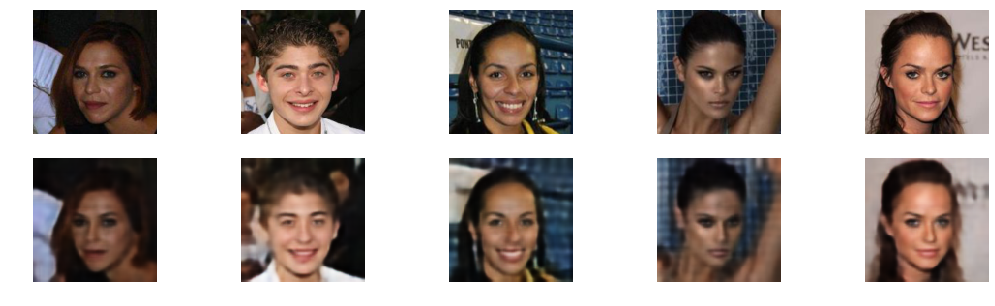

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


model = AutoEncoder(in_channels=3, dec_channels=32, latent_size=1000)
model = model.to(device)
model.load_state_dict(torch.load('autoencoder_i_20_%s.pt' % device))
model.eval()
torch.manual_seed(random_seed)

for batch_idx, features in enumerate(train_loader):
    features = features.to(device)
    logits, decoded = model(features)
    break



##########################
### VISUALIZATION
##########################

n_images = 5

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(18, 5))
orig_images = features.detach().cpu().numpy()[:n_images]
orig_images = np.moveaxis(orig_images, 1, -1)

decoded_images = decoded.detach().cpu().numpy()[:n_images]
decoded_images = np.moveaxis(decoded_images, 1, -1)


for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].axis('off')
        ax[i].imshow(img[i])

In [12]:
%watermark -iv

numpy       1.15.4
pandas      0.23.4
PIL.Image   5.3.0
torch       1.0.0

